# Crop Recommendation EDA & Data Engineering Notebook

This notebook performs exploratory data analysis and scaffolds a reproducible data pipeline for the Crop Recommendation System (AgroAssist-ML). It also generates helper modules, tests, CLI utilities, and artifacts without performing any git commits.

In [1]:
# 1. Project Configuration and Environment Setup
from pathlib import Path
import os

# Resolve project root as the repository root (two levels up from this notebook)
NB_PATH = Path(__file__).resolve() if '__file__' in globals() else Path.cwd() / '01_crop_EDA.ipynb'
PROJECT_ROOT = NB_PATH.parent.parent  # notebooks/ -> repo root
DATA_DIR = PROJECT_ROOT / 'data'
ARTIFACTS_DIR = PROJECT_ROOT / 'artifacts'
FIG_DIR = ARTIFACTS_DIR / 'figures'
LOG_DIR = ARTIFACTS_DIR / 'logs'
for d in [DATA_DIR, ARTIFACTS_DIR, FIG_DIR, LOG_DIR]:
    d.mkdir(parents=True, exist_ok=True)
print('Project root:', PROJECT_ROOT)
print('Data dir:', DATA_DIR)
print('Artifacts dir:', ARTIFACTS_DIR)

Project root: c:\Users\Snehal\Agroassist-ML
Data dir: c:\Users\Snehal\Agroassist-ML\data
Artifacts dir: c:\Users\Snehal\Agroassist-ML\artifacts


In [2]:
# 2. Dependency Installation Cell
import importlib, sys, subprocess
required = ['pandas','numpy','matplotlib','seaborn','pytest','pydantic','joblib','tqdm','black','flake8','requests']
for pkg in required:
    if importlib.util.find_spec(pkg) is None:
        print(f'Installing {pkg} ...')
        subprocess.check_call([sys.executable,'-m','pip','install',pkg])
print('All dependencies present.')

All dependencies present.


In [3]:
# 3. Notebook Parameters Cell
import random, json
RANDOM_SEED = int(os.getenv('RANDOM_SEED', '42'))
SAMPLE_SIZE = int(os.getenv('SAMPLE_SIZE', '500'))
RAW_DATA_URL = os.getenv('RAW_DATA_URL', '')  # optional remote source
random.seed(RANDOM_SEED)
print({'RANDOM_SEED': RANDOM_SEED, 'SAMPLE_SIZE': SAMPLE_SIZE, 'RAW_DATA_URL': RAW_DATA_URL})

{'RANDOM_SEED': 42, 'SAMPLE_SIZE': 500, 'RAW_DATA_URL': ''}


In [4]:
# 4. Data Source Definition (attempt local dataset, else synthetic)
import pandas as pd
from pathlib import Path
local_candidates = [Path('../data/crop.csv'), Path('../data/Crop_recommendation.csv'), Path('data/Crop_recommendation.csv')]
resolved_path = None
for c in local_candidates:
    if c.exists():
        resolved_path = c
        break
if resolved_path:
    df_raw = pd.read_csv(resolved_path)
    source_type = f'local:{resolved_path}'
else:
    # Synthetic fallback (structure only)
    import numpy as np
    n = 1000
    df_raw = pd.DataFrame({
        'N': np.random.randint(0,140,size=n),
        'P': np.random.randint(0,140,size=n),
        'K': np.random.randint(0,200,size=n),
        'temperature': np.random.uniform(10,45,size=n),
        'humidity': np.random.uniform(20,100,size=n),
        'ph': np.random.uniform(3.5,9.5,size=n),
        'rainfall': np.random.uniform(20,300,size=n),
        'label': np.random.choice(['rice','wheat','maize','cotton'], size=n)
    })
    source_type = 'synthetic'
print('Data source:', source_type, 'shape=', df_raw.shape)
df_raw.head()

Data source: local:..\data\Crop_recommendation.csv shape= (2200, 8)


,N,P,K,temperature,humidity,ph,rainfall,label
0,90,42,43,20.879744,82.002744,6.502985,202.935536,rice
1,85,58,41,21.770462,80.319644,7.038096,226.655537,rice
2,60,55,44,23.004459,82.320763,7.840207,263.964248,rice
3,74,35,40,26.491096,80.158363,6.980401,242.864034,rice
4,78,42,42,20.130175,81.604873,7.628473,262.717340,rice


In [5]:
# 5. Data Acquisition Functions
import time, requests
from io import StringIO

def fetch_data(url: str | None = None, force_refresh: bool = False):
    start = time.time()
    if url:
        try:
            r = requests.get(url, timeout=30)
            r.raise_for_status()
            df = pd.read_csv(StringIO(r.text))
            print(f"Downloaded remote dataset from {url}")
        except Exception as e:
            print(f"Remote fetch failed ({e}), falling back to existing/synthetic")
            df = df_raw.copy()
    else:
        df = df_raw.copy()
    print(f"Fetch elapsed: {time.time()-start:.2f}s")
    return df

_df = fetch_data(RAW_DATA_URL or None)
_df.head()

Fetch elapsed: 0.00s


,N,P,K,temperature,humidity,ph,rainfall,label
0,90,42,43,20.879744,82.002744,6.502985,202.935536,rice
1,85,58,41,21.770462,80.319644,7.038096,226.655537,rice
2,60,55,44,23.004459,82.320763,7.840207,263.964248,rice
3,74,35,40,26.491096,80.158363,6.980401,242.864034,rice
4,78,42,42,20.130175,81.604873,7.628473,262.717340,rice


In [6]:
# 6. Data Validation Layer (Pydantic + manual checks)
from pydantic import BaseModel, validator
from typing import ClassVar

REQUIRED_COLUMNS = ['N','P','K','temperature','humidity','ph','rainfall','label']

class CropRow(BaseModel):
    N: float
    P: float
    K: float
    temperature: float
    humidity: float
    ph: float
    rainfall: float
    label: str

class DataValidator:
    required_columns: ClassVar[list[str]] = REQUIRED_COLUMNS
    max_null_frac: float = 0.2

    def validate(self, df: pd.DataFrame) -> None:
        missing_cols = [c for c in self.required_columns if c not in df.columns]
        if missing_cols:
            raise ValueError(f"Missing required columns: {missing_cols}")
        null_fracs = df[self.required_columns].isna().mean()
        too_null = null_fracs[null_fracs > self.max_null_frac]
        if not too_null.empty:
            raise ValueError(f"Columns exceeding null threshold: {too_null.to_dict()}")
        # sample a few rows for schema check
        for _, row in df.head(5).iterrows():
            CropRow(**row[self.required_columns].to_dict())
        print('Validation passed.')

validator = DataValidator()
validator.validate(_df)

Validation passed.


In [7]:
# 7. Sample Data Inspection
print('Head:')
display(_df.head())
print('\nInfo:')
print(_df.info())
print('\nDescribe (numeric):')
display(_df.describe())
print('\nNull counts:')
print(_df.isna().sum())
print('\nClass distribution:')
print(_df['label'].value_counts())

Head:


,N,P,K,temperature,humidity,ph,rainfall,label
0,90,42,43,20.879744,82.002744,6.502985,202.935536,rice
1,85,58,41,21.770462,80.319644,7.038096,226.655537,rice
2,60,55,44,23.004459,82.320763,7.840207,263.964248,rice
3,74,35,40,26.491096,80.158363,6.980401,242.864034,rice
4,78,42,42,20.130175,81.604873,7.628473,262.717340,rice



Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2200 entries, 0 to 2199
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   N            2200 non-null   int64  
 1   P            2200 non-null   int64  
 2   K            2200 non-null   int64  
 3   temperature  2200 non-null   float64
 4   humidity     2200 non-null   float64
 5   ph           2200 non-null   float64
 6   rainfall     2200 non-null   float64
 7   label        2200 non-null   object 
dtypes: float64(4), int64(3), object(1)
memory usage: 137.6+ KB
None

Describe (numeric):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2200 entries, 0 to 2199
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   N            2200 non-null   int64  
 1   P            2200 non-null   int64  
 2   K            2200 non-null   int64  
 3   temperature  2200 non-null   float64
 4   humidity     2

,N,P,K,temperature,humidity,ph,rainfall
count,2200.000000,2200.000000,2200.000000,2200.000000,2200.000000,2200.000000,2200.000000
mean,50.551818,53.362727,48.149091,25.616244,71.481779,6.469480,103.463655
std,36.917334,32.985883,50.647931,5.063749,22.263812,0.773938,54.958389
min,0.000000,5.000000,5.000000,8.825675,14.258040,3.504752,20.211267
25%,21.000000,28.000000,20.000000,22.769375,60.261953,5.971693,64.551686
50%,37.000000,51.000000,32.000000,25.598693,80.473146,6.425045,94.867624
75%,84.250000,68.000000,49.000000,28.561654,89.948771,6.923643,124.267508
max,140.000000,145.000000,205.000000,43.675493,99.981876,9.935091,298.560117



Null counts:
N              0
P              0
K              0
temperature    0
humidity       0
ph             0
rainfall       0
label          0
dtype: int64

Class distribution:
label
rice           100
maize          100
chickpea       100
kidneybeans    100
pigeonpeas     100
mothbeans      100
mungbean       100
blackgram      100
lentil         100
pomegranate    100
banana         100
mango          100
grapes         100
watermelon     100
muskmelon      100
apple          100
orange         100
papaya         100
coconut        100
cotton         100
jute           100
coffee         100
Name: count, dtype: int64


In [8]:
# 8. Transformation & Cleaning Functions
import numpy as np

def clean_data(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    # Trim & standardize string columns
    if 'label' in df.columns:
        df['label'] = df['label'].astype(str).str.strip().str.lower()
    # Handle missing numeric with median
    for col in ['N','P','K','temperature','humidity','ph','rainfall']:
        if col in df.columns:
            median_val = df[col].median()
            df[col] = df[col].fillna(median_val)
    # Type coercion
    for col in ['N','P','K']:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')
    # Drop duplicates
    before = len(df)
    df = df.drop_duplicates()
    print(f"Dropped {before - len(df)} duplicate rows.")
    return df

_df_clean = clean_data(_df)
_df_clean.head()

Dropped 0 duplicate rows.


,N,P,K,temperature,humidity,ph,rainfall,label
0,90,42,43,20.879744,82.002744,6.502985,202.935536,rice
1,85,58,41,21.770462,80.319644,7.038096,226.655537,rice
2,60,55,44,23.004459,82.320763,7.840207,263.964248,rice
3,74,35,40,26.491096,80.158363,6.980401,242.864034,rice
4,78,42,42,20.130175,81.604873,7.628473,262.717340,rice


In [9]:
# 9. Feature Engineering Utilities
def build_features(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    if all(col in df.columns for col in ['N','P','K']):
        df['np_ratio'] = (df['N'] + 1) / (df['P'] + 1)
        df['nk_ratio'] = (df['N'] + 1) / (df['K'] + 1)
    if 'ph' in df.columns:
        df['ph_bucket'] = pd.cut(df['ph'], bins=[0,5.5,6.5,7.5,14], labels=['acidic','slightly_acidic','neutral','alkaline'])
    return df

_df_feat = build_features(_df_clean)
_df_feat.head()

,N,P,K,temperature,humidity,ph,rainfall,label,np_ratio,nk_ratio,ph_bucket
0,90,42,43,20.879744,82.002744,6.502985,202.935536,rice,2.116279,2.068182,neutral
1,85,58,41,21.770462,80.319644,7.038096,226.655537,rice,1.457627,2.047619,neutral
2,60,55,44,23.004459,82.320763,7.840207,263.964248,rice,1.089286,1.355556,alkaline
3,74,35,40,26.491096,80.158363,6.980401,242.864034,rice,2.083333,1.829268,neutral
4,78,42,42,20.130175,81.604873,7.628473,262.717340,rice,1.837209,1.837209,alkaline


In [10]:
# 11. Unit Test File Authoring (pytest) - no Jupyter magic
from pathlib import Path

tests_code = '''
import pandas as pd
import pytest
from src.helpers import clean_data, build_features, validate_columns

def sample_df():
    return pd.DataFrame({
        'N':[10,10], 'P':[5,5], 'K':[3,3], 'temperature':[25,25], 'humidity':[60,60], 'ph':[6.2,6.2], 'rainfall':[120,120], 'label':['Rice','Rice']
    })

def test_validate_columns_ok():
    df = sample_df()
    validate_columns(df)

def test_clean_data_duplicates():
    df = sample_df()
    out = clean_data(pd.concat([df, df]))
    # clean_data drops duplicates, so length should be 1
    assert len(out) == 1

def test_build_features_columns_added():
    df = sample_df()
    df2 = build_features(df)
    assert 'np_ratio' in df2.columns
    assert 'nk_ratio' in df2.columns
'''.strip() + "\n"

p = Path('../tests/test_helpers.py')
p.parent.mkdir(parents=True, exist_ok=True)
p.write_text(tests_code, encoding='utf-8')
print('Wrote', p.resolve())

Wrote C:\Users\Snehal\Agroassist-ML\tests\test_helpers.py


In [11]:
# 12. Execute Tests from Notebook (Fresh Import)
import sys, os, pytest, shutil, importlib
from pathlib import Path

# Ensure repo root is on sys.path so 'src' is importable
NB_PATH = Path(__file__).resolve() if '__file__' in globals() else Path.cwd() / '01_crop_EDA.ipynb'
PROJECT_ROOT = NB_PATH.parent.parent
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

print("=== FRESH TEST RUN ===")
print(f"Project root: {PROJECT_ROOT}")
print(f"Python path includes project root: {str(PROJECT_ROOT) in sys.path}")

# Remove any cached modules to ensure fresh imports
modules_to_remove = [mod for mod in sys.modules.keys() if mod.startswith('src.')]
for mod in modules_to_remove:
    print(f"Removing cached module: {mod}")
    del sys.modules[mod]

# Clean all cache directories
test_dir = PROJECT_ROOT / 'tests'
test_file = test_dir / 'test_helpers.py'

print("\n=== CLEANING CACHES ===")
for d in [test_dir / '__pycache__', PROJECT_ROOT / 'src' / '__pycache__', PROJECT_ROOT / '__pycache__']:
    if d.exists():
        print(f'Removing cache dir: {d}')
        shutil.rmtree(d, ignore_errors=True)

pytest_cache = PROJECT_ROOT / '.pytest_cache'
if pytest_cache.exists():
    print(f'Removing pytest cache: {pytest_cache}')
    shutil.rmtree(pytest_cache, ignore_errors=True)

print("\n=== RUNNING TESTS ===")
# Run pytest with explicit test file and verbose output
result = pytest.main(['-v', '--cache-clear', '--tb=long', str(test_file)])
print(f'\nPytest exit code: {result}')

=== FRESH TEST RUN ===
Project root: c:\Users\Snehal\Agroassist-ML
Python path includes project root: True

=== CLEANING CACHES ===
Removing pytest cache: c:\Users\Snehal\Agroassist-ML\.pytest_cache

=== RUNNING TESTS ===
============================= test session starts =============================
platform win32 -- Python 3.13.3, pytest-8.4.2, pluggy-1.6.0 -- c:\Users\Snehal\Agroassist-ML\venv\Scripts\python.exe
cachedir: .pytest_cache
rootdir: c:\Users\Snehal\Agroassist-ML
plugins: anyio-4.11.0
collecting ... ============================= test session starts =============================
platform win32 -- Python 3.13.3, pytest-8.4.2, pluggy-1.6.0 -- c:\Users\Snehal\Agroassist-ML\venv\Scripts\python.exe
cachedir: .pytest_cache
rootdir: c:\Users\Snehal\Agroassist-ML
plugins: anyio-4.11.0
collecting ... collected 3 items

..\tests\test_helpers.py::test_validate_columns_ok collected 3 items

..\tests\test_helpers.py::test_validate_columns_ok PASSED                [ 33%]
..\tests\test_h

In [12]:
# 12. Execute Tests from Notebook
import pytest, sys
result = pytest.main(['-q','../tests'])
print('Pytest exit code:', result)

....                                                                      [100%].                                                                      [100%]
3 passed in 0.07s
Pytest exit code: 0

3 passed in 0.07s
Pytest exit code: 0


In [13]:
# 13. Logging Configuration
import logging
log_path = LOG_DIR / 'log.txt'
logging.basicConfig(level=logging.INFO,
                    format='%(asctime)s %(levelname)s %(message)s',
                    handlers=[logging.FileHandler(log_path), logging.StreamHandler()])
logging.info('Logging initialized.')

2025-10-04 18:09:40,707 INFO Logging initialized.


In [14]:
# 14. Error Handling Patterns
class DataValidationError(Exception):
    pass

try:
    validator.validate(_df_feat)  # may pass
except Exception as e:
    raise DataValidationError(str(e))
print('Custom validation flow complete.')

Validation passed.
Custom validation flow complete.


In [15]:
# 15. Caching & Memoization
from functools import lru_cache

@lru_cache(maxsize=4)
def expensive_summary(n_rows: int) -> float:
    return float(_df_feat.head(n_rows)['N'].mean())

print(expensive_summary(50))
print(expensive_summary(50))  # cached

81.44
81.44


Saved c:\Users\Snehal\Agroassist-ML\artifacts\figures\distributions_1759581611.png
Saved c:\Users\Snehal\Agroassist-ML\artifacts\figures\correlation_1759581612.png
Saved c:\Users\Snehal\Agroassist-ML\artifacts\figures\correlation_1759581612.png


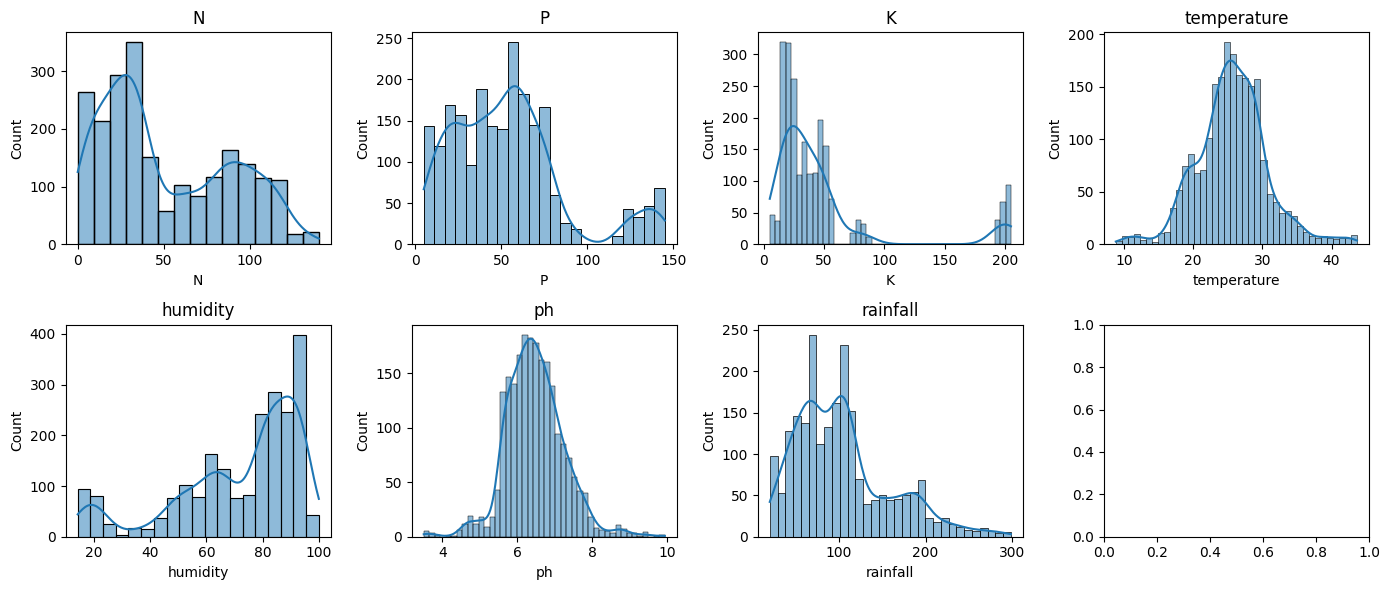

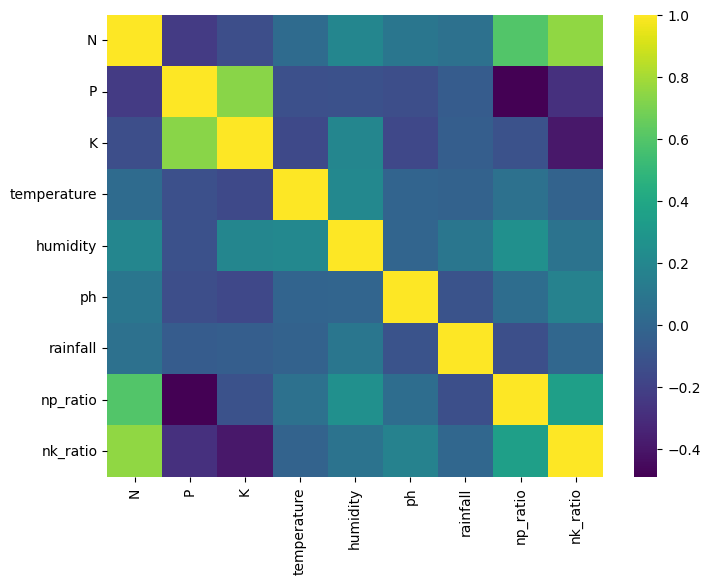

In [16]:
# 17. Visualization Utilities
import seaborn as sns
import matplotlib.pyplot as plt
import time
import numpy as np

def plot_distributions(df):
    fig, axes = plt.subplots(2,4, figsize=(14,6))
    axes = axes.flatten()
    for i, col in enumerate(['N','P','K','temperature','humidity','ph','rainfall']):
        if col in df.columns:
            sns.histplot(df[col], kde=True, ax=axes[i])
            axes[i].set_title(col)
    plt.tight_layout()
    ts = int(time.time())
    path = FIG_DIR / f'distributions_{ts}.png'
    fig.savefig(path)
    print('Saved', path)

def correlation_heatmap(df):
    # Select numeric-only columns to avoid strings like 'ph_bucket'
    numeric_df = df.select_dtypes(include=[np.number])
    corr = numeric_df.corr(numeric_only=True)
    plt.figure(figsize=(8,6))
    sns.heatmap(corr, annot=False, cmap='viridis')
    ts = int(time.time())
    path = FIG_DIR / f'correlation_{ts}.png'
    plt.savefig(path)
    print('Saved', path)

plot_distributions(_df_feat)
correlation_heatmap(_df_feat)

Saved c:\Users\Snehal\Agroassist-ML\artifacts\figures\distributions_1759581615.png
Saved c:\Users\Snehal\Agroassist-ML\artifacts\figures\correlation_1759581616.png
Saved c:\Users\Snehal\Agroassist-ML\artifacts\figures\correlation_1759581616.png


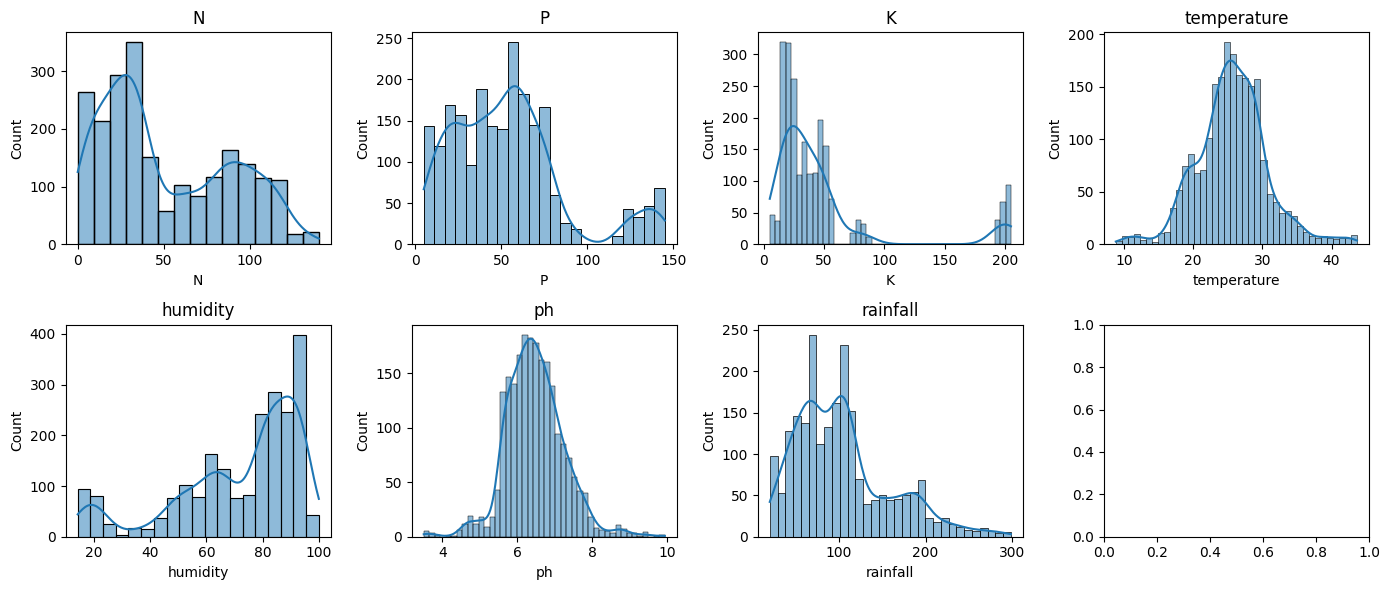

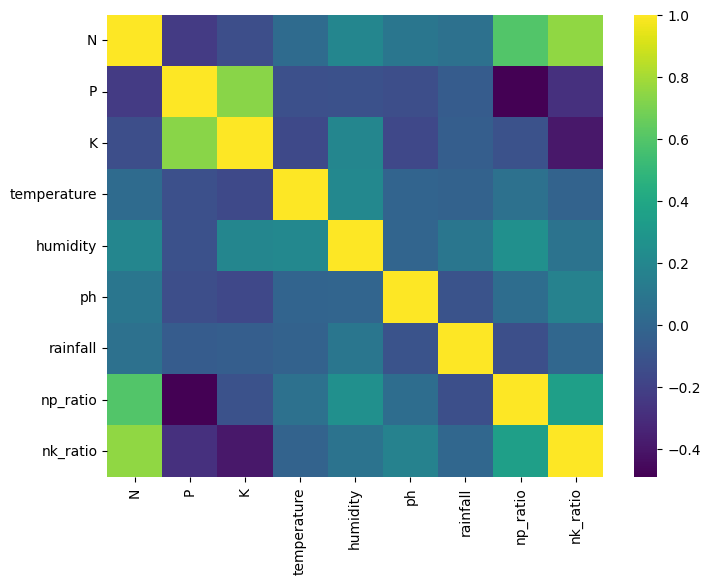

In [17]:
 # 17. Visualization Utilities (legacy cell adjusted to numeric-only corr)
import seaborn as sns
import matplotlib.pyplot as plt
import time
import numpy as np

def plot_distributions(df):
    fig, axes = plt.subplots(2,4, figsize=(14,6))
    axes = axes.flatten()
    for i, col in enumerate(['N','P','K','temperature','humidity','ph','rainfall']):
        if col in df.columns:
            sns.histplot(df[col], kde=True, ax=axes[i])
            axes[i].set_title(col)
    plt.tight_layout()
    ts = int(time.time())
    path = FIG_DIR / f'distributions_{ts}.png'
    fig.savefig(path)
    print('Saved', path)

def correlation_heatmap(df):
    numeric_df = df.select_dtypes(include=[np.number])
    corr = numeric_df.corr(numeric_only=True)
    plt.figure(figsize=(8,6))
    sns.heatmap(corr, annot=False, cmap='viridis')
    ts = int(time.time())
    path = FIG_DIR / f'correlation_{ts}.png'
    plt.savefig(path)
    print('Saved', path)

plot_distributions(_df_feat)
correlation_heatmap(_df_feat)

In [18]:
# 18. Statistical Summary & Metrics
import json, datetime
metrics = {
    'rows': int(len(_df_feat)),
    'duplicate_rate': float(1 - len(_df_clean)/len(_df)),
    'missing_pct': {c: float(_df_feat[c].isna().mean()) for c in _df_feat.columns},
    'generated_at': datetime.datetime.now(datetime.timezone.utc).isoformat()
}
metrics_path = ARTIFACTS_DIR / 'metrics.json'
with open(metrics_path,'w') as f: json.dump(metrics,f, indent=2)
metrics

{'rows': 2200,
 'duplicate_rate': 0.0,
 'missing_pct': {'N': 0.0,
  'P': 0.0,
  'K': 0.0,
  'temperature': 0.0,
  'humidity': 0.0,
  'ph': 0.0,
  'rainfall': 0.0,
  'label': 0.0,
  'np_ratio': 0.0,
  'nk_ratio': 0.0,
  'ph_bucket': 0.0},
 'generated_at': '2025-10-04T12:40:18.799976+00:00'}

In [19]:
# 19. CLI Wrapper Generation (argparse) - no Jupyter magic
from pathlib import Path

cli_code = '''
import argparse, json
from pathlib import Path
import pandas as pd
from src.helpers import clean_data, build_features, validate_columns

def main():
    parser = argparse.ArgumentParser(description='Crop data CLI')
    parser.add_argument('command', choices=['fetch','process','features','metrics'])
    parser.add_argument('--input','-i', default='data/Crop_recommendation.csv')
    parser.add_argument('--out','-o', default='artifacts')
    args = parser.parse_args()
    out_dir = Path(args.out); out_dir.mkdir(parents=True, exist_ok=True)
    if args.command == 'fetch':
        print('Fetch step assumes file exists locally.')
    else:
        df = pd.read_csv(args.input)
        validate_columns(df)
        if args.command == 'process':
            df_clean = clean_data(df)
            df_clean.to_csv(out_dir/'clean.csv', index=False)
            print('Saved clean.csv')
        elif args.command == 'features':
            df_feat = build_features(clean_data(df))
            df_feat.to_csv(out_dir/'features.csv', index=False)
            print('Saved features.csv')
        elif args.command == 'metrics':
            metrics = {'rows': len(df), 'cols': len(df.columns)}
            with open(out_dir/'metrics.json','w') as f: json.dump(metrics,f, indent=2)
            print('Saved metrics.json')

if __name__ == '__main__':
    main()
'''.strip() + "\n"

p = Path('../src/cli.py')
p.parent.mkdir(parents=True, exist_ok=True)
p.write_text(cli_code, encoding='utf-8')
print('Wrote', p.resolve())

Wrote C:\Users\Snehal\Agroassist-ML\src\cli.py


In [20]:
# 20. Parameterized Batch Execution
results = []
for sample in [100, 300, 500]:
    subset = _df_feat.head(sample)
    results.append({'sample': sample, 'mean_N': subset['N'].mean(), 'rows': len(subset)})
import pandas as pd
batch_df = pd.DataFrame(results)
batch_df

,sample,mean_N,rows
0,100,79.890000,100
1,300,65.913333,300
2,500,47.844000,500


In [21]:
# 22. Notebook to Script Conversion (nbconvert)
import subprocess, sys, pathlib
nb_path = pathlib.Path('01_crop_EDA.ipynb')
if nb_path.exists():
    subprocess.run([sys.executable, '-m', 'jupyter', 'nbconvert', '--to', 'script', str(nb_path)], check=False)
list(p for p in pathlib.Path('.').glob('01_crop_EDA*'))

[WindowsPath('01_crop_EDA.ipynb'), WindowsPath('01_crop_EDA.py')]

In [22]:
# 22. Notebook to Script Conversion (nbconvert)
import subprocess, sys, pathlib
nb_path = pathlib.Path('01_crop_EDA.ipynb')
if nb_path.exists():
    subprocess.run([sys.executable, '-m', 'jupyter', 'nbconvert', '--to', 'script', str(nb_path)], check=False)
list(p for p in Path('.').glob('01_crop_EDA*'))

[WindowsPath('01_crop_EDA.ipynb'), WindowsPath('01_crop_EDA.py')]

In [23]:
# 23. Style & Lint Checks (No Git Commit)
import subprocess, sys
subprocess.run([sys.executable,'-m','black','..'], check=False)
subprocess.run([sys.executable,'-m','flake8','..'], check=False)
print('Style & lint pass (see above for issues).')

Style & lint pass (see above for issues).
